# Keyword Extraction for analyzing popularity of Algorithms
### By
### Preksha Mutha, Snehal Kenjale, Kiranmai Nallamalli, Omkaar Khanvilkar

In [2]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
from pyspark.ml.feature import CountVectorizer, MinHashLSH
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

#### Loading Dataset from Mongodb 

In [3]:
spark = SparkSession \
    .builder \
    .appName("myProject") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/projectDB.papers") \
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.0' ) \
    .getOrCreate()
data = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [4]:
content_rdd = data.select("paper_text").rdd.flatMap(lambda x: x)

#### Data preprocessing

In [5]:
lowerCase_sentRDD = content_rdd.map(lambda x : x.lower())

In [6]:
def sent_TokenizeFunct(x):
    nltk.data.path.append("/share/apps/python/3.6.5/data/nltk")
    return nltk.sent_tokenize(x)
sentenceTokenizeRDD = lowerCase_sentRDD.map(sent_TokenizeFunct)

In [7]:
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted
wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

In [75]:
wordTokenizeRDD.take(5)

[['"767',
  'self-organization',
  'of',
  'associative',
  'database',
  'and',
  'its',
  'applications',
  'hisashi',
  'suzuki',
  'and',
  'suguru',
  'arimoto',
  'osaka',
  'university',
  'toyonaka',
  'osaka',
  '560',
  'japan',
  'abstract',
  'an',
  'efficient',
  'method',
  'of',
  'self-organizing',
  'associative',
  'databases',
  'is',
  'proposed',
  'together',
  'with',
  'applications',
  'to',
  'robot',
  'eyesight',
  'systems.',
  'the',
  'proposed',
  'databases',
  'can',
  'associate',
  'any',
  'input',
  'with',
  'some',
  'output.',
  'in',
  'the',
  'first',
  'half',
  'part',
  'of',
  'discussion',
  'an',
  'algorithm',
  'of',
  'self-organization',
  'is',
  'proposed.',
  'from',
  'an',
  'aspect',
  'of',
  'hardware',
  'it',
  'produces',
  'a',
  'new',
  'style',
  'of',
  'neural',
  'network.',
  'in',
  'the',
  'latter',
  'half',
  'part',
  'an',
  'applicability',
  'to',
  'handwritten',
  'letter',
  'recognition',
  'and',
  

In [8]:
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence
stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

In [9]:
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [76]:
rmvPunctRDD.take(5)

[['767',
  'selforganization',
  'associative',
  'database',
  'applications',
  'hisashi',
  'suzuki',
  'suguru',
  'arimoto',
  'osaka',
  'university',
  'toyonaka',
  'osaka',
  '560',
  'japan',
  'abstract',
  'efficient',
  'method',
  'selforganizing',
  'associative',
  'databases',
  'proposed',
  'together',
  'applications',
  'robot',
  'eyesight',
  'systems',
  'proposed',
  'databases',
  'associate',
  'input',
  'output',
  'first',
  'half',
  'part',
  'discussion',
  'algorithm',
  'selforganization',
  'proposed',
  'aspect',
  'hardware',
  'produces',
  'new',
  'style',
  'neural',
  'network',
  'latter',
  'half',
  'part',
  'applicability',
  'handwritten',
  'letter',
  'recognition',
  'autonomous',
  'mobile',
  'robot',
  'system',
  'demonstrated',
  'introduction',
  'let',
  'mapping',
  'f',
  '',
  'x',
  '',
  'given',
  'x',
  'finite',
  'infinite',
  'set',
  'another',
  'finite',
  'infinite',
  'set',
  'learning',
  'machine',
  'observes

In [10]:
def rem_single_characters(lst):
    outputlst = []
    for word in lst:
        temp = re.sub('[^a-zA-Z ]+',' ', word) 
        temp=re.sub("&lt;/?.*?&gt;",' ',temp)
        temp=re.sub("(\\d|\\W)+"," ",temp)
        if(len(temp)<=3):
            outputlst.append(' ')        
        else:
            outputlst.append(temp)
    return outputlst

In [11]:
rem_chara_RDD = rmvPunctRDD.map(rem_single_characters)

In [12]:
rem_chara_RDD.take(5)

[[' ',
  'selforganization',
  'associative',
  'database',
  'applications',
  'hisashi',
  'suzuki',
  'suguru',
  'arimoto',
  'osaka',
  'university',
  'toyonaka',
  'osaka',
  ' ',
  'japan',
  'abstract',
  'efficient',
  'method',
  'selforganizing',
  'associative',
  'databases',
  'proposed',
  'together',
  'applications',
  'robot',
  'eyesight',
  'systems',
  'proposed',
  'databases',
  'associate',
  'input',
  'output',
  'first',
  'half',
  'part',
  'discussion',
  'algorithm',
  'selforganization',
  'proposed',
  'aspect',
  'hardware',
  'produces',
  ' ',
  'style',
  'neural',
  'network',
  'latter',
  'half',
  'part',
  'applicability',
  'handwritten',
  'letter',
  'recognition',
  'autonomous',
  'mobile',
  'robot',
  'system',
  'demonstrated',
  'introduction',
  ' ',
  'mapping',
  ' ',
  ' ',
  ' ',
  ' ',
  'given',
  ' ',
  'finite',
  'infinite',
  ' ',
  'another',
  'finite',
  'infinite',
  ' ',
  'learning',
  'machine',
  'observes',
  ' ',


In [13]:
def lemmatizationFunct(x):
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem
lem_wordsRDD = rem_chara_RDD.map(lemmatizationFunct)

In [14]:
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x
joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [77]:
joinedTokens.take(2)

['  selforganization associative database application hisashi suzuki suguru arimoto osaka university toyonaka osaka   japan abstract efficient method selforganizing associative database proposed together application robot eyesight system proposed database associate input output first half part discussion algorithm selforganization proposed aspect hardware produce   style neural network latter half part applicability handwritten letter recognition autonomous mobile robot system demonstrated introduction   mapping         given   finite infinite   another finite infinite   learning machine observes   pair     sampled randomly           mean cartesian product     computes estimate           make small estimation error measure usually   that faster decrease estimation error increase number sample better learning machine however expression performance incomplete since lack consideration candidate     assumed preliminarily find good learning machine clarify conception     discus type learnin

In [15]:
def removecharacters(text):   
    text=text.strip()
    text = re.sub('\s+', ' ', text).strip()
    return text

In [16]:
rem_spacesRDD = joinedTokens.map(removecharacters)

In [17]:
rem_spacesRDD.take(5)

['selforganization associative database application hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative database proposed together application robot eyesight system proposed database associate input output first half part discussion algorithm selforganization proposed aspect hardware produce style neural network latter half part applicability handwritten letter recognition autonomous mobile robot system demonstrated introduction mapping given finite infinite another finite infinite learning machine observes pair sampled randomly mean cartesian product computes estimate make small estimation error measure usually that faster decrease estimation error increase number sample better learning machine however expression performance incomplete since lack consideration candidate assumed preliminarily find good learning machine clarify conception discus type learning machine advance understanding selforganization associative d

In [18]:
wordsRDD = rem_spacesRDD.map(lambda x : x).flatMap(lambda word: word.split(" "))

In [19]:
wordsRDD.take(5)

['selforganization', 'associative', 'database', 'application', 'hisashi']

In [20]:
wordcounts = rem_spacesRDD.map(lambda x : x).flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)

In [21]:
wordcounts.take(5)

[('selforganization', 298),
 ('associative', 1320),
 ('database', 3963),
 ('hisashi', 25),
 ('university', 13566)]

In [22]:
sorted_words = wordcounts.takeOrdered(len(wordcounts.collect()),key=lambda x: -x[1])

In [23]:
plot_word_list = sorted_words[:25]

In [24]:
plot_word_list

[('model', 150984),
 ('algorithm', 115837),
 ('learning', 104005),
 ('function', 96738),
 ('data', 91776),
 ('network', 76318),
 ('method', 73024),
 ('problem', 72250),
 ('using', 67961),
 ('result', 64272),
 ('time', 60113),
 ('distribution', 59938),
 ('number', 57145),
 ('figure', 54992),
 ('matrix', 51319),
 ('parameter', 49976),
 ('value', 49575),
 ('feature', 49096),
 ('image', 48323),
 ('also', 46775),
 ('training', 46156),
 ('given', 45829),
 ('used', 45541),
 ('show', 44910),
 ('neural', 44543)]

In [25]:
# removing additional unnecesary words
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]

In [26]:
filteredWords = [word for word in sorted_words if word not in new_words]

In [27]:
filteredWords

[('model', 150984),
 ('algorithm', 115837),
 ('learning', 104005),
 ('function', 96738),
 ('data', 91776),
 ('network', 76318),
 ('method', 73024),
 ('problem', 72250),
 ('using', 67961),
 ('result', 64272),
 ('time', 60113),
 ('distribution', 59938),
 ('number', 57145),
 ('figure', 54992),
 ('matrix', 51319),
 ('parameter', 49976),
 ('value', 49575),
 ('feature', 49096),
 ('image', 48323),
 ('also', 46775),
 ('training', 46156),
 ('given', 45829),
 ('used', 45541),
 ('show', 44910),
 ('neural', 44543),
 ('point', 41967),
 ('case', 41802),
 ('example', 41745),
 ('approach', 41515),
 ('error', 41401),
 ('input', 41383),
 ('vector', 40562),
 ('probability', 40258),
 ('information', 40245),
 ('system', 39892),
 ('state', 39721),
 ('sample', 38845),
 ('bound', 38140),
 ('first', 37878),
 ('different', 36488),
 ('variable', 35002),
 ('performance', 33431),
 ('space', 33402),
 ('linear', 32284),
 ('kernel', 31160),
 ('section', 30760),
 ('work', 29771),
 ('random', 29392),
 ('weight', 29365)

In [28]:
from pyspark.sql import *

In [29]:
finaldf = rem_spacesRDD.map(lambda x : [x])

In [30]:
finaldf.take(5)

[['selforganization associative database application hisashi suzuki suguru arimoto osaka university toyonaka osaka japan abstract efficient method selforganizing associative database proposed together application robot eyesight system proposed database associate input output first half part discussion algorithm selforganization proposed aspect hardware produce style neural network latter half part applicability handwritten letter recognition autonomous mobile robot system demonstrated introduction mapping given finite infinite another finite infinite learning machine observes pair sampled randomly mean cartesian product computes estimate make small estimation error measure usually that faster decrease estimation error increase number sample better learning machine however expression performance incomplete since lack consideration candidate assumed preliminarily find good learning machine clarify conception discus type learning machine advance understanding selforganization associative 

In [31]:
finaldf1 = sqlContext.createDataFrame(finaldf,['text'])

In [32]:
finaldf1.show()

+--------------------+
|                text|
+--------------------+
|selforganization ...|
|mean field theory...|
|storing covarianc...|
|bayesian query co...|
|neural network en...|
|sing neural insta...|
|plasticitymediate...|
|iceg morphology c...|
|realtime control ...|
|realtime control ...|
|learning play gam...|
|multidimensional ...|
|experimental comp...|
|training multilay...|
|interference lear...|
|active learning s...|
|rapid graphbased ...|
|ocular dominance ...|
|associative decor...|
|connectionist tec...|
+--------------------+
only showing top 20 rows



In [33]:
from pyspark.sql import functions as F

In [34]:
concat_list = udf(lambda lst: " ".join(lst), StringType())

df1 = finaldf1.withColumn("combined", concat_list("text"))

In [35]:
finaldf2 = finaldf1.withColumn("words", F.split(finaldf1['text'], ' '))

In [36]:
finaldf2.show()

+--------------------+--------------------+
|                text|               words|
+--------------------+--------------------+
|selforganization ...|[selforganization...|
|mean field theory...|[mean, field, the...|
|storing covarianc...|[storing, covaria...|
|bayesian query co...|[bayesian, query,...|
|neural network en...|[neural, network,...|
|sing neural insta...|[sing, neural, in...|
|plasticitymediate...|[plasticitymediat...|
|iceg morphology c...|[iceg, morphology...|
|realtime control ...|[realtime, contro...|
|realtime control ...|[realtime, contro...|
|learning play gam...|[learning, play, ...|
|multidimensional ...|[multidimensional...|
|experimental comp...|[experimental, co...|
|training multilay...|[training, multil...|
|interference lear...|[interference, le...|
|active learning s...|[active, learning...|
|rapid graphbased ...|[rapid, graphbase...|
|ocular dominance ...|[ocular, dominanc...|
|associative decor...|[associative, dec...|
|connectionist tec...|[connectio

#### Models

In [37]:
from pyspark.ml.feature import NGram

In [38]:
bigram = NGram(n=2, inputCol="words", outputCol="bigrams")
bigramDataFrame = bigram.transform(finaldf2)

In [68]:
topbigrams = bigramDataFrame.withColumn('topbigrams', F.explode(F.col('bigrams')))\
    .groupBy('topbigrams')\
    .count()\
    .sort('count', ascending=False)

In [69]:
topbigrams.select('topbigrams').show(10)

+--------------------+
|          topbigrams|
+--------------------+
|      neural network|
|    machine learning|
|information proce...|
|  neural information|
|   processing system|
|  learning algorithm|
|international con...|
|         figure show|
|         lower bound|
|      advance neural|
+--------------------+
only showing top 10 rows



In [39]:
trigram = NGram(n=3, inputCol="words", outputCol="trigrams")
trigramDataFrame = trigram.transform(bigramDataFrame)

In [40]:
topwords = trigramDataFrame.withColumn('word', F.explode(F.col('trigrams')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [41]:
topwords.select('word').show(10)

+--------------------+
|                word|
+--------------------+
|neural informatio...|
|information proce...|
|advance neural in...|
|arxiv preprint arxiv|
|conference machin...|
|international con...|
|machine learning ...|
|journal machine l...|
|processing system...|
|proceeding intern...|
+--------------------+
only showing top 10 rows



In [42]:
topwords.write.csv('topwords_trigrams1.csv')

In [43]:
list_trigrams = topwords.select("word").rdd.flatMap(lambda x: x)

In [79]:
list_trigrams.take(5)

['neural information processing',
 'information processing system',
 'advance neural information',
 'arxiv preprint arxiv',
 'conference machine learning']

In [54]:
df = pd.read_csv("trigrams_list.csv")

In [55]:
tri_lsit = df["neural information processing"]

In [56]:
tri = tri_lsit.tolist()

In [57]:
tri

['information processing system',
 'advance neural information',
 'arxiv preprint arxiv',
 'conference machine learning',
 'international conference machine',
 'machine learning research',
 'journal machine learning',
 'processing system page',
 'proceeding international conference',
 'support vector machine',
 'processing system nip',
 'department computer science',
 'recurrent neural network',
 'hidden markov model',
 'conference neural information',
 'stochastic gradient descent',
 'conference computer vision',
 'machine learning icml',
 'convolutional neural network',
 'principal component analysis',
 'conference artificial intelligence',
 'deep neural network',
 'cambridge university press',
 'vision pattern recognition',
 'computer vision pattern',
 'machine learning page',
 'markov decision process',
 'editor advance neural',
 'latent variable model',
 'computer science university',
 'pattern analysis machine',
 'without loss generality',
 'analysis machine intelligence',
 'unce

In [58]:
res2 = [k for k in tri if 'network' in k]

In [59]:
res3 = [k for k in res2 if 'learning' not in res2]

In [60]:
res = [k for k in tri if 'algorithm' in k]

In [61]:
res2

['recurrent neural network',
 'convolutional neural network',
 'deep neural network',
 'artificial neural network',
 'neural network model',
 'feedforward neural network',
 'generative adversarial network',
 'network advance neural',
 'network arxiv preprint',
 'neural network architecture',
 'learning neural network',
 'using neural network',
 'deep belief network',
 'transaction neural network',
 'conference neural network',
 'training neural network',
 'deep convolutional network',
 'neural network arxiv',
 'neural network advance',
 'neural network neural',
 'neural network learning',
 'dynamic bayesian network',
 'basis function network',
 'neural network nip',
 'network neural computation',
 'neural network ieee',
 'model neural network',
 'network hidden unit',
 'network machine learning',
 'network hidden layer',
 'neural network trained',
 'learning bayesian network',
 'multilayer neural network',
 'neural network hidden',
 'network computation neural',
 'sigmoid belief networ

In [62]:
# Using inbuilt list to filter out alogithms
algo_list = ["expectation maximization algorithm","","","active learning problem","gradient descent algorithm","polynoial time algorithm","deep reinforcement learning","dehaene–changeux model","dynamic time warping","error-driven learning","evolutionary multimodal optimization","expectation–maximization algorithm","forward–backward algorithm","growing self-organizing map","hyper basis function network","nearest neighbor algorithm","principal component analysis","local outlier factor","logic learning machine","multiple kernel learning","out-of-bag error","non-negative matrix factorization","radial basis function network","support vector machine","logistic regression algorithm","linear regression algorithm","reinforcement learning","rule-based machine learning","stochastic gradient descent","k-nearest neighbour","temporal difference learning","Weighted majority algorithm"," algorithm kmeans clustering","collaborative filtering algorithm","recurrent neural network","reinforcement learning","decission tree classification","randon forest classifiers","voting classifier algorithm","convolution neural network","deep neural network","naive bayes algorithm","generative adversarial network","wake sleep algorithm"]

In [63]:
top_algos = list(set(tri).intersection(algo_list))

In [64]:
df.rename(columns={"neural information processing": "Algorithms", "8990": "Count"},inplace=True)

In [65]:
final_df = df[df["Algorithms"].isin(top_algos)]

In [66]:
final_df

,Algorithms,Count
9,support vector machine,2345
12,recurrent neural network,1489
15,stochastic gradient descent,1363
19,principal component analysis,1259
21,deep neural network,1171
96,generative adversarial network,441
106,gradient descent algorithm,424
114,multiple kernel learning,404
208,temporal difference learning,274
217,deep reinforcement learning,263


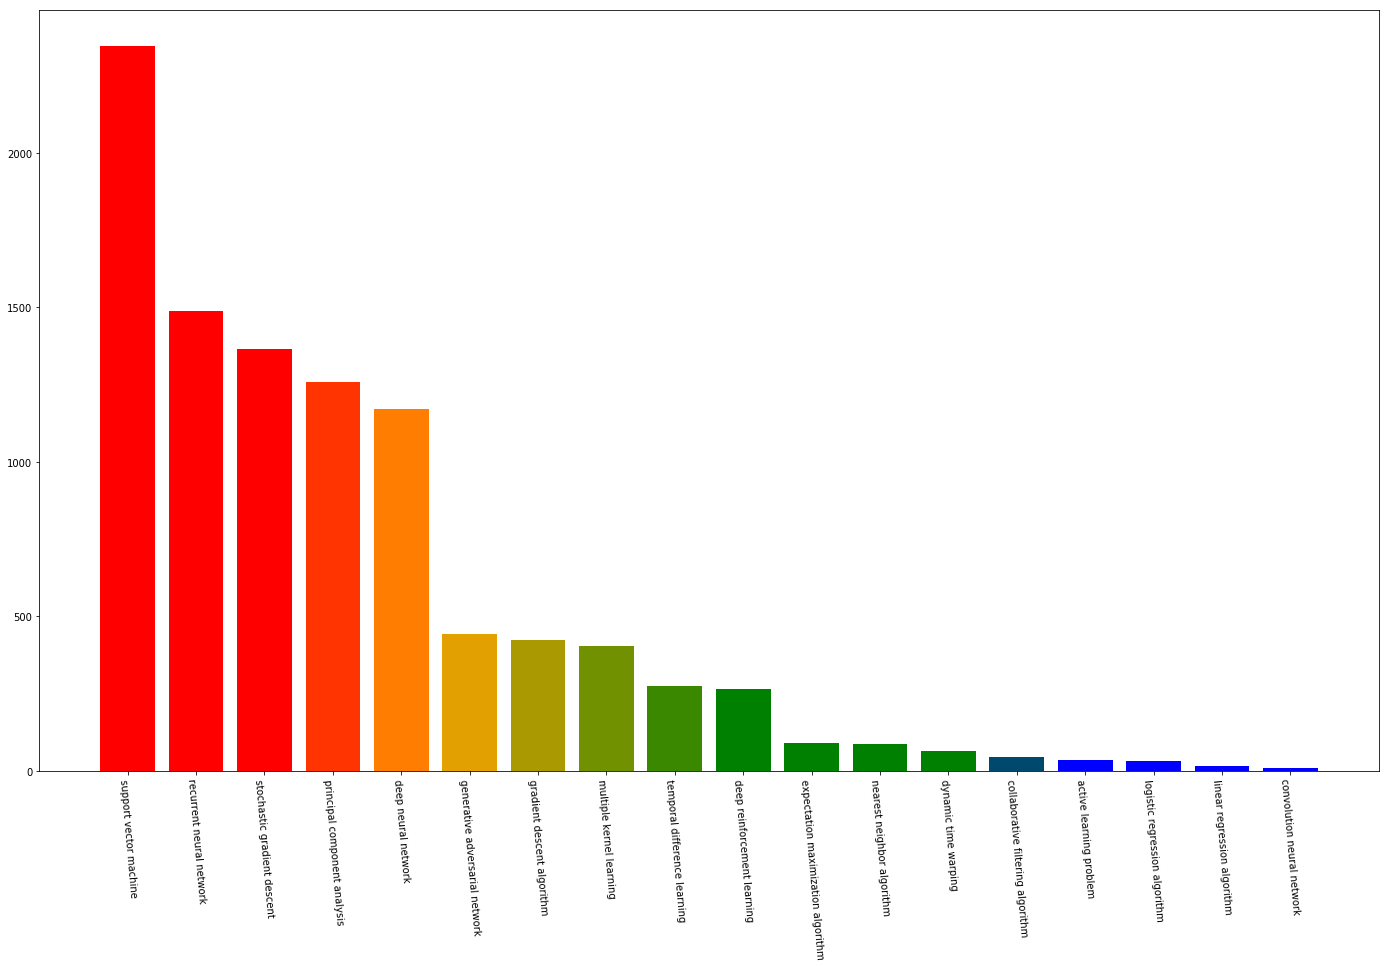

In [67]:
clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

algo = final_df["Algorithms"]
count = final_df["Count"]

N = len(algo)
x = np.arange(N).astype(float)
plt.figure(figsize=(24,14))
plt.bar(algo,count, color=rvb(x/N))
plt.xticks(algo, rotation=-85)
plt.show()

In [94]:
res1 = [k for k in res if 'learning' not in k]

In [95]:
res1

['gradient descent algorithm',
 'dynamic programming algorithm',
 'belief propagation algorithm',
 'message passing algorithm',
 'polynomial time algorithm',
 'coordinate descent algorithm',
 'incomplete data algorithm',
 'symposium discrete algorithm',
 'approximate inference algorithm',
 'monte carlo algorithm',
 'running time algorithm',
 'variational inference algorithm',
 'algorithm advance neural',
 'stochastic approximation algorithm',
 'algorithm journal royal',
 'spectral clustering algorithm',
 'algorithm ieee transaction',
 'algorithm neural network',
 'data algorithm journal',
 'algorithm neural computation',
 'feature selection algorithm',
 'algorithm described section',
 'stochastic gradient algorithm',
 'gibbs sampling algorithm',
 'policy iteration algorithm',
 'convergence rate algorithm',
 'algorithm deep belief',
 'expectation maximization algorithm',
 'weighted majority algorithm',
 'algorithm linear inverse',
 'algorithm guaranteed converge',
 'computationally effi

In [117]:
top_algos

['support vector machine',
 'stochastic gradient descent',
 'gradient descent algorithm',
 'linear regression algorithm',
 'convolution neural network',
 'collaborative filtering algorithm',
 'expectation maximization algorithm',
 'temporal difference learning',
 'generative adversarial network',
 'logistic regression algorithm',
 'active learning problem',
 'recurrent neural network',
 'deep reinforcement learning',
 'principal component analysis',
 'deep neural network',
 'nearest neighbor algorithm',
 'dynamic time warping',
 'multiple kernel learning']

In [44]:
countVectorizer = CountVectorizer(inputCol="trigrams", outputCol="features", vocabSize = 100000, minDF=2)
cv_model = countVectorizer.fit(trigramDataFrame)
result = cv_model.transform(trigramDataFrame)

In [45]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|               words|             bigrams|            trigrams|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|selforganization ...|[selforganization...|[selforganization...|[selforganization...|(100000,[150,398,...|
|mean field theory...|[mean, field, the...|[mean field, fiel...|[mean field theor...|(100000,[47,50,11...|
|storing covarianc...|[storing, covaria...|[storing covarian...|[storing covarian...|(100000,[87,195,3...|
|bayesian query co...|[bayesian, query,...|[bayesian query, ...|[bayesian query c...|(100000,[34,35,39...|
|neural network en...|[neural, network,...|[neural network, ...|[neural network e...|(100000,[0,1,2,31...|
|sing neural insta...|[sing, neural, in...|[sing neural, neu...|[sing neural inst...|(100000,[0,1,2,8,...|
|plasticitymediate...|[plasticitymedi

In [47]:
idf = IDF(inputCol="features", outputCol="IDFfeatures")
idfModel = idf.fit(result)
rescaledData = idfModel.transform(result)

#### Results 

In [48]:
rescaledData.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|               words|             bigrams|            trigrams|            features|         IDFfeatures|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|selforganization ...|[selforganization...|[selforganization...|[selforganization...|(100000,[150,398,...|(100000,[150,398,...|
|mean field theory...|[mean, field, the...|[mean field, fiel...|[mean field theor...|(100000,[47,50,11...|(100000,[47,50,11...|
|storing covarianc...|[storing, covaria...|[storing covarian...|[storing covarian...|(100000,[87,195,3...|(100000,[87,195,3...|
|bayesian query co...|[bayesian, query,...|[bayesian query, ...|[bayesian query c...|(100000,[34,35,39...|(100000,[34,35,39...|
|neural network en...|[neural, network,...|[neural network, ...|[neural network e...|(100000,[0,1,2,31..

#### Trying out LDA model for clustering data (Future scope)

In [ ]:
corpus = result.select("text", "features").rdd.map(lambda z: [z[0],Vectors.fromML(z[1])]).cache()

# Cluster the documents into three topics using LDA
ldaModel = LDA.train(corpus, k=3,maxIterations=100,optimizer='online')
topics = ldaModel.topicsMatrix()
vocabArray = model.vocabulary

wordNumbers = 15  # number of words per topic
topicIndices = sc.parallelize(ldaModel.describeTopics(maxTermsPerTopic = wordNumbers))

def topic_render(topic):  # specify vector id of words to actual words
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()

for topic in range(len(topics_final)):
    print ("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print (term)
    print ('\n')

In [97]:
counts = result.select('features').collect()

In [103]:
len(counts)

7239

In [94]:
voc = cv_model.vocabulary

In [101]:
len(voc)

100000

In [99]:
final_words = dict(zip(cv_model.vocabulary, counts[0]['features'].values))

In [100]:
len(final_words)

37